<a href="https://colab.research.google.com/github/tejjusbhat/SaaS-Customer-Churn-Prediction/blob/main/Churn_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd

In [6]:
df = pd.read_csv("saas_churn_clean.csv")

In [7]:
df.head()

,age,gender,region_category,joined_through_referral,preferred_offer_types,medium_of_operation,internet_option,days_since_last_login,avg_session_duration,avg_transaction_value,...,session_minutes_90d,days_since_active,api_calls_90d_log,api_usage_bucket,recency_bucket,logins_per_active_day,minutes_per_login,usage_intensity,tenure_days,last_visit_hour
0,18,F,Village,No,Gift Vouchers/Coupons,?,Wi-Fi,17.0,300.63,53005.25,...,1027.11,2,9.081825,2,0,1.352941,21.853404,32.566667,2918,16
1,32,F,City,?,Gift Vouchers/Coupons,Desktop,Mobile_Data,16.0,306.34,12838.38,...,862.65,1,9.060215,2,0,1.193548,22.701316,47.805556,2907,12
2,44,F,Town,Yes,Gift Vouchers/Coupons,Desktop,Wi-Fi,14.0,516.16,21027.00,...,411.37,16,5.590987,0,1,0.944444,22.853889,0.174510,3197,22
3,37,M,City,Yes,Gift Vouchers/Coupons,Desktop,Mobile_Data,11.0,53.27,25239.56,...,215.77,20,5.429346,0,1,0.888889,23.974444,0.120106,3210,15
4,31,F,City,No,Credit/Debit Card Offers,Smartphone,Mobile_Data,20.0,113.13,24483.66,...,231.94,2,5.686975,0,0,1.083333,16.567143,1.088889,2892,15


In [8]:
y = df["churn"]
X = df.drop(columns=["churn"])

In [9]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

In [10]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier

cat_cols = X.select_dtypes(include=["object", "category"]).columns.tolist()
num_cols = X.select_dtypes(exclude=["object", "category"]).columns.tolist()

preprocessor = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(drop="first", handle_unknown="ignore"), cat_cols),
        ("num", "passthrough", num_cols)
    ]
)

model = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("classifier", XGBClassifier(
        eval_metric="logloss",
        random_state=42
    ))
])

In [11]:
model.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'),
                                                  ['gender', 'region_category',
                                                   'joined_through_referral',
                                                   'preferred_offer_types',
                                                   'medium_of_operation',
                                                   'internet_option',
                                                   'used_special_discount',
                                                   'offer_application_preference',
                                                   'past_complaint',
                                                   'complaint_status',
                                                   'feedback', 'plan_t...
                               feature_types=None, feature_weights=None,
                               gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=None, n_jobs=None,
                               num_parallel_tree=None, ...))])

In [13]:
from sklearn.metrics import classification_report, roc_auc_score

y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]

print(classification_report(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_prob))

              precision    recall  f1-score   support

           0       0.94      0.91      0.93      3396
           1       0.93      0.95      0.94      4003

    accuracy                           0.93      7399
   macro avg       0.93      0.93      0.93      7399
weighted avg       0.93      0.93      0.93      7399

ROC AUC: 0.9747857687417594


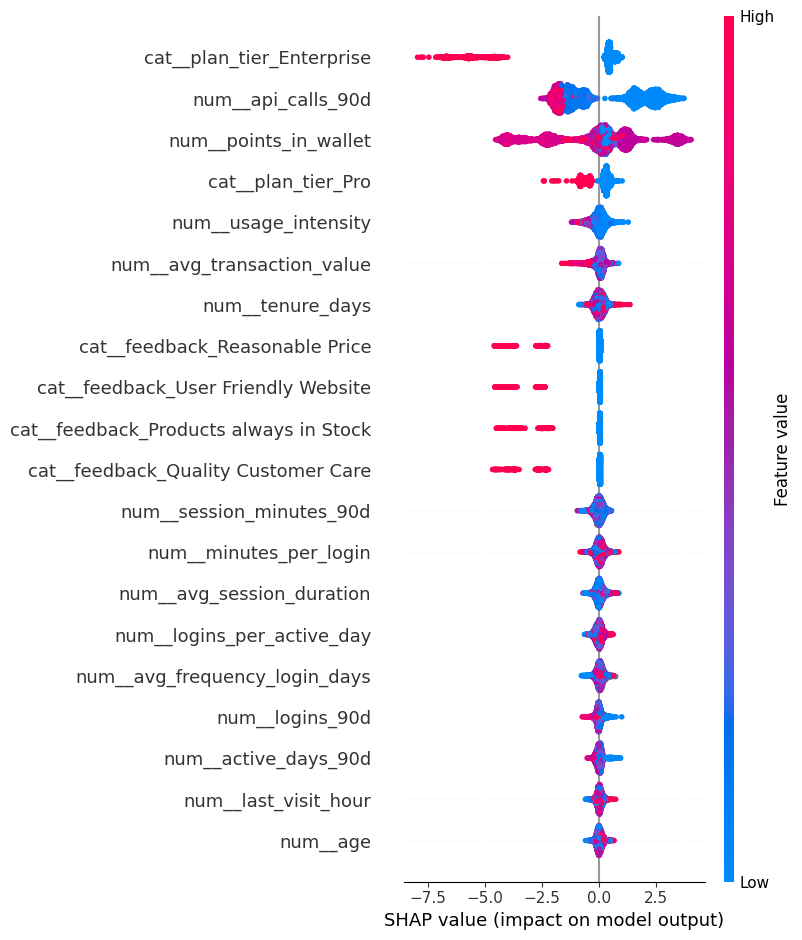

In [14]:
import shap

# Extract trained XGBoost model from pipeline
xgb_model = model.named_steps["classifier"]

# Transform X_test for SHAP
X_test_transformed = model.named_steps["preprocessor"].transform(X_test)

explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer.shap_values(X_test_transformed)

shap.summary_plot(shap_values, X_test_transformed, feature_names=model.named_steps["preprocessor"].get_feature_names_out())